# SARIMAX with monthly data

it turned out that SARIMAX cannot handle daily data with a seasonality of one year, so I used the monthly data

In [1]:
#import of the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.stattools import adfuller,kpss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import itertools

warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')

<AxesSubplot:xlabel='date'>

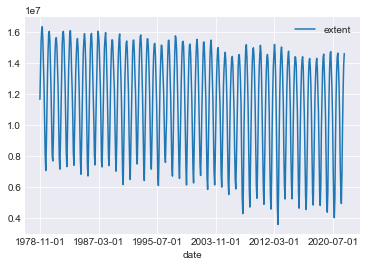

In [2]:
df_month_ext = pd.read_csv('../data/N_monthly.csv')
df_month_ext.plot(x='date', y='extent')

In [3]:
df_month_mod = df_month_ext[['date','extent']]
df_month_mod['date'] = pd.to_datetime(df_month_mod['date'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.304730
p-value: 0.627005
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.697406
p-value: 0.010000
----------------------------------------


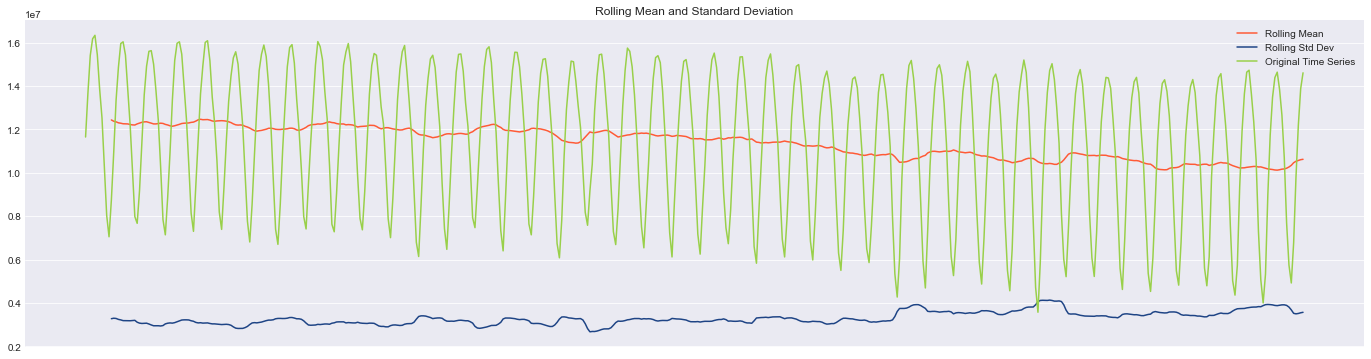

In [4]:
# checking for stationarity 

def stationarity_test(extent, t):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = extent.rolling(t).mean()
    rolling_std_dev = extent.rolling(t).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
stationarity_test(df_month_ext['extent'],12)

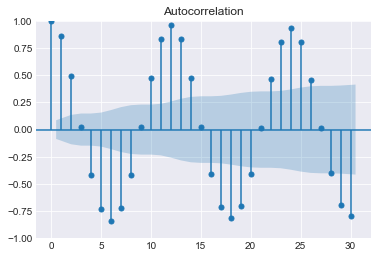

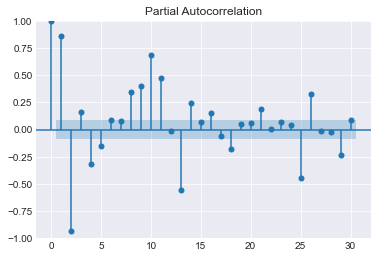

In [5]:
plot_acf(df_month_ext['extent'], lags=30)
plt.show()
plot_pacf(df_month_ext['extent'], lags=30)
plt.show()

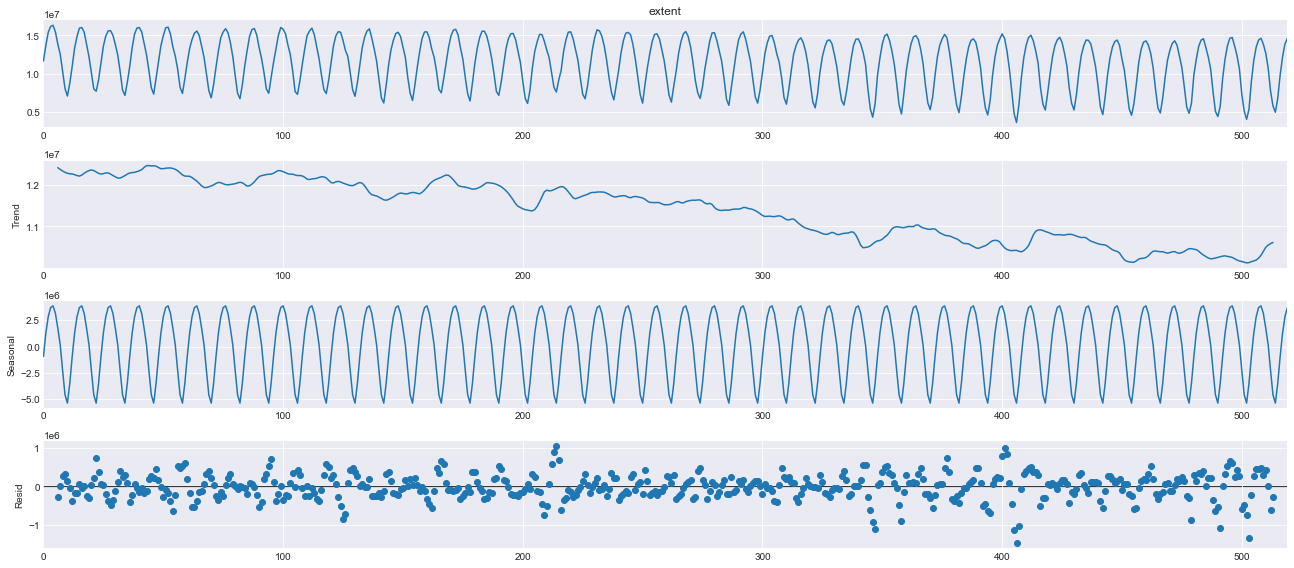

In [6]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_month_mod['extent'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

In [7]:
# split into train and test sets (we use the last five years as test-data)

X_month = df_month_mod['extent']

train_size = int(len(X_month)*0.881)
train_month, test_month = X_month[1:train_size], X_month[train_size:]
print('Observations: %d' % (len(X_month)))
print('Training Observations: %d' % (len(train_month)))
print('Testing Observations: %d' % (len(test_month)))

Observations: 520
Training Observations: 457
Testing Observations: 62


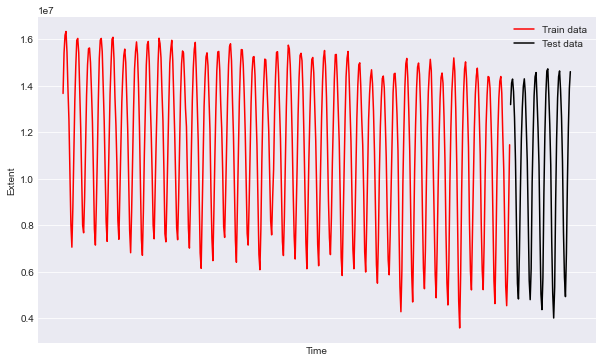

In [8]:
# Plotting the train and test set

plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train_month, 'red', label='Train data')
plt.plot(test_month, 'black', label='Test data')
plt.legend();

#### grid search for finding the best hyperparameters 
takes a lot af time, therefor it's commented out
--> results: ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:11726.822336158482

In [9]:
#import itertools

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37207D+01    |proj g|=  8.88177D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.882D-08   1.372D+01
  F =   13.720749546982301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32181D+01    |proj g|=  2.94454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   1.947D-06   1.322D+01
  F =   13.218121564123154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:12085.363109608563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33323D+01    |proj g|=  6.40476D+00


 This problem is unconstrained.



At iterate    5    f=  1.27988D+01    |proj g|=  5.18013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   7.124D-06   1.280D+01
  F =   12.796969617842738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:11702.430230708262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32221D+01    |proj g|=  6.58336D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31758D+01    |proj g|=  1.48576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.609D-06   1.318D+01
  F =   13.175811957747079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:12048.69212938083
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32862D+01    |proj g|=  3.51548D+00


 This problem is unconstrained.



At iterate    5    f=  1.28169D+01    |proj g|=  6.51476D-02

At iterate   10    f=  1.27926D+01    |proj g|=  2.73336D-02

At iterate   15    f=  1.27921D+01    |proj g|=  1.30106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   1.301D-05   1.279D+01
  F =   12.792139249690631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:11700.015274217238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:11731.300568823395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28254D+01    |proj g|=  1.57345D-02


 This problem is unconstrained.



At iterate    5    f=  1.28246D+01    |proj g|=  1.31071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.796D-06   1.282D+01
  F =   12.824615004681595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:11729.698114278977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31939D+01    |proj g|=  2.83394D+00


 This problem is unconstrained.



At iterate    5    f=  1.27965D+01    |proj g|=  1.37035D-02

At iterate   10    f=  1.27931D+01    |proj g|=  2.14192D-02

At iterate   15    f=  1.27904D+01    |proj g|=  5.89537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   7.772D-05   1.279D+01
  F =   12.790376430846006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:11700.40405779325
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32046D+01    |proj g|=  7.68300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.576D-07   1.320D+01
  F =   13.204539271069038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:12074.9488937571
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32102D+01    |proj g|=  4.97139D+00


 This problem is unconstrained.



At iterate    5    f=  1.27947D+01    |proj g|=  4.88696D-02

At iterate   10    f=  1.27938D+01    |proj g|=  2.07569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   7.497D-06   1.279D+01
  F =   12.793846908544497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:11701.57607440967
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32456D+01    |proj g|=  6.06761D-02

           * *

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31935D+01    |proj g|=  3.05315D-01

At iterate    5    f=  1.31729D+01    |proj g|=  8.54081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   5.867D-06   1.317D+01
  F =   13.172876507566246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:12048.009127915548


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31099D+01    |proj g|=  2.24202D+00

At iterate    5    f=  1.28092D+01    |proj g|=  4.15028D-02

At iterate   10    f=  1.27942D+01    |proj g|=  1.95855D-02

At iterate   15    f=  1.27938D+01    |proj g|=  5.06141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.403D-06   1.279D+01
  F =   12.793820292436600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      8      1     0     0   8.814D-07   1.286D+01
  F =   12.859633193507527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:11761.70473886588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28577D+01    |proj g|=  1.16353D-02


 This problem is unconstrained.



At iterate    5    f=  1.28570D+01    |proj g|=  2.56989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   3.128D-06   1.286D+01
  F =   12.857007034348397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:11761.304429394435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30508D+01    |proj g|=  1.80493D+00


 This problem is unconstrained.



At iterate    5    f=  1.27968D+01    |proj g|=  8.96910D-03

At iterate   10    f=  1.27946D+01    |proj g|=  1.23491D-02

At iterate   15    f=  1.27930D+01    |proj g|=  7.53385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   4.623D-06   1.279D+01
  F =   12.792951259476030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:11704.757451161091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31421D+01    |proj g|=  7.99986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.609D-06   1.314D+01
  F =   13.142069108795248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:12019.851165438857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31706D+01    |proj g|=  5.29034D+00


 This problem is unconstrained.



At iterate    5    f=  1.27318D+01    |proj g|=  5.43285D-02

At iterate   10    f=  1.27289D+01    |proj g|=  4.58101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   9.660D-07   1.273D+01
  F =   12.728903896882130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:11644.218161750267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32247D+01    |proj g|=  4.98770D-02

At iterate   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31325D+01    |proj g|=  3.34507D-01

At iterate    5    f=  1.31096D+01    |proj g|=  6.20412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.556D-05   1.311D+01
  F =   13.109636408016989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:11992.207676927528


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30640D+01    |proj g|=  2.39823D+00

At iterate    5    f=  1.27439D+01    |proj g|=  5.97659D-02

At iterate   10    f=  1.27293D+01    |proj g|=  1.75324D-02

At iterate   15    f=  1.27289D+01    |proj g|=  8.44591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   4.260D-05   1.273D+01
  F =   12.728856528246704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0,

 This problem is unconstrained.



At iterate    5    f=  1.28283D+01    |proj g|=  3.77430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     10      1     0     0   3.774D-05   1.283D+01
  F =   12.828337358776412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:11735.10034592164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28270D+01    |proj g|=  2.11958D-02


 This problem is unconstrained.



At iterate    5    f=  1.28249D+01    |proj g|=  1.43692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   4.584D-06   1.282D+01
  F =   12.824764275919916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:11733.834548190804
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30010D+01    |proj g|=  1.92919D+00


 This problem is unconstrained.



At iterate    5    f=  1.27317D+01    |proj g|=  8.51934D-03

At iterate   10    f=  1.27308D+01    |proj g|=  1.12828D-02

At iterate   15    f=  1.27282D+01    |proj g|=  4.21609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     26      1     0     0   5.502D-06   1.273D+01
  F =   12.728189789518385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:11647.565467619805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.770D-06   1.323D+01
  F =   13.234388510398684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:12102.231098504397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32421D+01    |proj g|=  4.99738D+00


 This problem is unconstrained.



At iterate    5    f=  1.28255D+01    |proj g|=  4.19969D-02

At iterate   10    f=  1.28239D+01    |proj g|=  4.19554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   9.022D-07   1.282D+01
  F =   12.823900551376093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:11729.04510395775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32141D+01    |proj g|=  2.96097D-02

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32031D+01    |proj g|=  9.94833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.038D-05   1.320D+01
  F =   13.203124027521879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:12075.655361154997
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31411D+01    |proj g|=  2.25423D+00


 This problem is unconstrained.



At iterate    5    f=  1.28396D+01    |proj g|=  4.25235D-02

At iterate   10    f=  1.28242D+01    |proj g|=  1.87020D-02

At iterate   15    f=  1.28239D+01    |proj g|=  3.10514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   8.426D-06   1.282D+01
  F =   12.823885729333444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:11731.031556610767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:11732.801290438776
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28257D+01    |proj g|=  1.51728D-02


 This problem is unconstrained.



At iterate    5    f=  1.28247D+01    |proj g|=  1.21715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   1.187D-06   1.282D+01
  F =   12.824660568686859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:11731.73975977979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30817D+01    |proj g|=  1.81580D+00


 This problem is unconstrained.



At iterate    5    f=  1.28268D+01    |proj g|=  8.78716D-03

At iterate   10    f=  1.28247D+01    |proj g|=  1.20896D-02

At iterate   15    f=  1.28230D+01    |proj g|=  1.89302D-02

At iterate   20    f=  1.28228D+01    |proj g|=  1.00059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   1.001D-04   1.282D+01
  F =   12.822825704686430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:11732.062694083397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32019D+01    |proj g|=  1.20276D-02

At iterate   10    f=  1.31964D+01    |proj g|=  3.35427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.108D-05   1.320D+01
  F =   13.195830011130539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:12068.988630173313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32048D+01    |proj g|=  4.86331D+00


 This problem is unconstrained.



At iterate    5    f=  1.27950D+01    |proj g|=  4.64505D-02

At iterate   10    f=  1.27904D+01    |proj g|=  1.62538D-01

At iterate   15    f=  1.27798D+01    |proj g|=  9.61132D-03

At iterate   20    f=  1.27797D+01    |proj g|=  1.25265D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   2.334D-06   1.278D+01
  F =   12.779737999362471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:11690.680531417298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  1.32029D+01    |proj g|=  4.84614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   2.290D-06   1.320D+01
  F =   13.202875364167172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:12075.428082848795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31930D+01    |proj g|=  3.02520D-01


 This problem is unconstrained.



At iterate    5    f=  1.31716D+01    |proj g|=  1.27394D-02

At iterate   10    f=  1.31628D+01    |proj g|=  1.46426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     21      1     0     0   5.139D-05   1.316D+01
  F =   13.162664690830375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:12040.675527418964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31049D+01    |proj g|=  2.18920D+00


 This problem is unconstrained.



At iterate    5    f=  1.28093D+01    |proj g|=  3.98740D-02

At iterate   10    f=  1.27799D+01    |proj g|=  4.43215D-02

At iterate   15    f=  1.27787D+01    |proj g|=  6.62073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   5.041D-05   1.278D+01
  F =   12.778628881391271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:11691.66679759162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  1.28215D+01    |proj g|=  1.16365D-01

At iterate   10    f=  1.28110D+01    |proj g|=  2.47865D-02

At iterate   15    f=  1.28107D+01    |proj g|=  2.05933D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     31      1     0     0   2.059D-06   1.281D+01
  F =   12.810734227725561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:11719.011084141162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28193D+01    |proj g|=  6.44261D-02

At iterate   10    f=  1.28099D+01    |proj g|=  2.28210D-02

At iterate   15    f=  1.28095D+01    |proj g|=  1.44713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     27      1     0     0   4.043D-05   1.281D+01
  F =   12.809473927014499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:11719.859169291252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27961D+01    |proj g|=  8.84040D-03

At iterate   10    f=  1.27858D+01    |proj g|=  9.12757D-02

At iterate   15    f=  1.27771D+01    |proj g|=  8.41167D-03

At iterate   20    f=  1.27753D+01    |proj g|=  3.01249D-02

At iterate   25    f=  1.27746D+01    |proj g|=  5.30012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     41      1     0     0   2.057D-05   1.277D+01
  F =   12.774603726536691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:11689.987806054536
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32598D+01    |proj g|=  3.59367D-01

At iterate   10    f=  1.31427D+01    |proj g|=  1.89294D-02

At iterate   15    f=  1.31324D+01    |proj g|=  1.69394D-02

At iterate   20    f=  1.31321D+01    |proj g|=  5.72697D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.727D-06   1.313D+01
  F =   13.132078692921597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:12012.71992533034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  1.28689D+01    |proj g|=  3.48647D-01

At iterate   10    f=  1.27303D+01    |proj g|=  1.22463D-02

At iterate   15    f=  1.27146D+01    |proj g|=  6.00440D-02

At iterate   20    f=  1.27129D+01    |proj g|=  2.51967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   4.171D-05   1.271D+01
  F =   12.712935476600258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:11631.623025612636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  1.31759D+01    |proj g|=  1.15274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.050D-05   1.318D+01
  F =   13.175926345981296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:12052.796680226904


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90942D+01    |proj g|=  3.38093D+02

At iterate    5    f=  1.31150D+01    |proj g|=  1.36915D-01

At iterate   10    f=  1.30969D+01    |proj g|=  1.46578D-02

At iterate   15    f=  1.30956D+01    |proj g|=  2.17039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   4.352D-06   1.310D+01
  F =   13.095617317599062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1,

 This problem is unconstrained.



At iterate    5    f=  1.28747D+01    |proj g|=  3.87199D-01

At iterate   10    f=  1.27396D+01    |proj g|=  2.56210D-02

At iterate   15    f=  1.27232D+01    |proj g|=  5.10269D-02

At iterate   20    f=  1.27128D+01    |proj g|=  1.61686D-02

At iterate   25    f=  1.27122D+01    |proj g|=  1.72502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   7.782D-06   1.271D+01
  F =   12.712187689276954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:11632.939547999136
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  1.27994D+01    |proj g|=  1.16053D-01

At iterate   10    f=  1.27800D+01    |proj g|=  2.94737D-02

At iterate   15    f=  1.27790D+01    |proj g|=  6.53749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   9.953D-06   1.278D+01
  F =   12.778954100920188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:11691.964048241052


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51485D+01    |proj g|=  1.68650D+02

At iterate    5    f=  1.27898D+01    |proj g|=  8.76628D-02

At iterate   10    f=  1.27781D+01    |proj g|=  2.48471D-02

At iterate   15    f=  1.27769D+01    |proj g|=  1.96362D-03

At iterate   20    f=  1.27769D+01    |proj g|=  2.34857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     24      1     0     0   2.349D-05   1.278D+01
  F =   12.776879828581549     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60588D+01    |proj g|=  7.96016D+02

At iterate    5    f=  1.28473D+01    |proj g|=  3.36260D-01

At iterate   10    f=  1.27296D+01    |proj g|=  1.56053D-02

At iterate   15    f=  1.27191D+01    |proj g|=  5.99607D-02

At iterate   20    f=  1.27135D+01    |proj g|=  6.33283D-03

At iterate   25    f=  1.27131D+01    |proj g|=  1.86132D-02

At iterate   30    f=  1.27111D+01    |proj g|=  1.64222D-02

At iterate   35    f=  1.27108D+01    |proj g|=  1.80434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32130D+01    |proj g|=  1.75931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.382D-06   1.321D+01
  F =   13.212958786877032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:12084.644331205607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32144D+01    |proj g|=  5.00766D+00


 This problem is unconstrained.



At iterate    5    f=  1.28020D+01    |proj g|=  4.15510D-02

At iterate   10    f=  1.28004D+01    |proj g|=  2.25794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   2.258D-05   1.280D+01
  F =   12.800369865506260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:11709.538057072721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31575D+01    |proj g|=  3.50058D-02

           * 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31670D+01    |proj g|=  3.04656D-01

At iterate    5    f=  1.31465D+01    |proj g|=  7.69464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.272D-06   1.315D+01
  F =   13.146488995512893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:12025.890941898784


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31156D+01    |proj g|=  2.28131D+00

At iterate    5    f=  1.28128D+01    |proj g|=  4.88486D-02

At iterate   10    f=  1.28008D+01    |proj g|=  2.07540D-02

At iterate   15    f=  1.28003D+01    |proj g|=  8.78217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.575D-05   1.280D+01
  F =   12.800323246994148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.27739D+01    |proj g|=  1.62570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   8.125D-06   1.277D+01
  F =   12.773852249212784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:11685.300955780483
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27717D+01    |proj g|=  2.17553D-02


 This problem is unconstrained.



At iterate    5    f=  1.27696D+01    |proj g|=  5.80859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   1.249D-06   1.277D+01
  F =   12.769559204903038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:11683.377113281376
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30261D+01    |proj g|=  1.83718D+00


 This problem is unconstrained.



At iterate    5    f=  1.27713D+01    |proj g|=  9.26799D-03

At iterate   10    f=  1.27696D+01    |proj g|=  7.75633D-03

At iterate   15    f=  1.27680D+01    |proj g|=  4.98575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     27      1     0     0   4.938D-05   1.277D+01
  F =   12.767970947790968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:11683.925446280944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31713D+01    |proj g|=  1.08273D-02

At iterate   10    f=  1.31700D+01    |proj g|=  1.30773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.689D-06   1.317D+01
  F =   13.170021882819984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:12047.400000897465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31810D+01    |proj g|=  4.97065D+00


 This problem is unconstrained.



At iterate    5    f=  1.27632D+01    |proj g|=  5.12572D-02

At iterate   10    f=  1.27564D+01    |proj g|=  1.51685D-01

At iterate   15    f=  1.27531D+01    |proj g|=  4.55197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   1.640D-05   1.275D+01
  F =   12.753083478128953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:11668.318299009863
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.31449D+01    |proj g|=  3.29953D-02

At iterate   10    f=  1.31439D+01    |proj g|=  2.77440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     20      1     0     0   3.177D-06   1.314D+01
  F =   13.143888626188478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:12023.514204336268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31625D+01    |proj g|=  3.18043D-01


 This problem is unconstrained.



At iterate    5    f=  1.31396D+01    |proj g|=  9.76553D-03

At iterate   10    f=  1.31381D+01    |proj g|=  3.16008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   9.205D-06   1.314D+01
  F =   13.138049252660627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:12020.177016931813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30789D+01    |proj g|=  2.24711D+00


 This problem is unconstrained.



At iterate    5    f=  1.27747D+01    |proj g|=  3.50632D-02

At iterate   10    f=  1.27535D+01    |proj g|=  7.70053D-02

At iterate   15    f=  1.27521D+01    |proj g|=  2.39890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     27      1     0     0   4.115D-05   1.275D+01
  F =   12.752082870051591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:11669.403743227154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27594D+01    |proj g|=  5.85404D-02

At iterate   10    f=  1.27549D+01    |proj g|=  6.51857D-03

At iterate   15    f=  1.27548D+01    |proj g|=  1.93575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     23      1     0     0   1.936D-05   1.275D+01
  F =   12.754807467764818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:11669.894025537043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27568D+01    |proj g|=  3.97864D-02

At iterate   10    f=  1.27537D+01    |proj g|=  5.74817D-03

At iterate   15    f=  1.27533D+01    |proj g|=  1.05915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     26      1     0     0   1.525D-05   1.275D+01
  F =   12.753344032474024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:11670.556445681257


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30200D+01    |proj g|=  1.81447D+00

At iterate    5    f=  1.27633D+01    |proj g|=  1.42083D-02

At iterate   10    f=  1.27566D+01    |proj g|=  6.06585D-02

At iterate   15    f=  1.27538D+01    |proj g|=  7.89010D-04

At iterate   20    f=  1.27535D+01    |proj g|=  1.67954D-02

At iterate   25    f=  1.27523D+01    |proj g|=  6.31314D-02

At iterate   30    f=  1.27504D+01    |proj g|=  1.21205D-02

At iterate   35    f=  1.27503D+01    |proj g|=  7.38774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   20    f=  1.38154D+01    |proj g|=  1.01143D+00

At iterate   25    f=  1.37261D+01    |proj g|=  2.59594D+01

At iterate   30    f=  1.36944D+01    |proj g|=  1.72174D-01

At iterate   35    f=  1.36934D+01    |proj g|=  1.86051D+00

At iterate   40    f=  1.36851D+01    |proj g|=  1.87866D+00

At iterate   45    f=  1.36794D+01    |proj g|=  5.00618D+00

At iterate   50    f=  1.36750D+01    |proj g|=  2.77384D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     83      1     0     0   2.774D+00   1.367D+01
  F =   13.674970348854350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.33359D+01    |proj g|=  9.07468D-02

At iterate   15    f=  1.32885D+01    |proj g|=  1.78581D-01

At iterate   20    f=  1.32390D+01    |proj g|=  4.91974D-01

At iterate   25    f=  1.32261D+01    |proj g|=  9.93191D-01

At iterate   30    f=  1.32222D+01    |proj g|=  2.15407D-01

At iterate   35    f=  1.32215D+01    |proj g|=  1.23926D-01

At iterate   40    f=  1.32214D+01    |proj g|=  2.30184D-03

At iterate   45    f=  1.32214D+01    |proj g|=  1.50680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     81      1     0     0   1.507D-02   1.322D+01
  F =   13.2214086620


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.31517D+01    |proj g|=  2.55098D-01

At iterate   10    f=  1.30825D+01    |proj g|=  2.53115D-01

At iterate   15    f=  1.28111D+01    |proj g|=  5.96097D-01

At iterate   20    f=  1.27270D+01    |proj g|=  1.53792D-01

At iterate   25    f=  1.27185D+01    |proj g|=  4.05177D-02

At iterate   30    f=  1.27117D+01    |proj g|=  4.02152D-02

At iterate   35    f=  1.27113D+01    |proj g|=  1.38707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     62      1     0     0   3.267D-05   1.271D+01
  F =   12.711330011923270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.33907D+01    |proj g|=  3.63592D-01

At iterate   15    f=  1.33639D+01    |proj g|=  2.55360D-01

At iterate   20    f=  1.32468D+01    |proj g|=  1.42506D-01

At iterate   25    f=  1.32443D+01    |proj g|=  7.00063D-01

At iterate   30    f=  1.32429D+01    |proj g|=  9.77867D-01

At iterate   35    f=  1.32412D+01    |proj g|=  1.52455D-01

At iterate   40    f=  1.32409D+01    |proj g|=  8.31696D-02

At iterate   45    f=  1.32359D+01    |proj g|=  9.38041D-02

At iterate   50    f=  1.32355D+01    |proj g|=  4.52622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate    5    f=  1.33101D+01    |proj g|=  8.86826D-02

At iterate   10    f=  1.32657D+01    |proj g|=  2.23326D-01

At iterate   15    f=  1.32237D+01    |proj g|=  6.46207D-01

At iterate   20    f=  1.32062D+01    |proj g|=  6.82688D-01

At iterate   25    f=  1.32033D+01    |proj g|=  1.16752D-01

At iterate   30    f=  1.32031D+01    |proj g|=  1.22694D-01

At iterate   35    f=  1.31995D+01    |proj g|=  5.41779D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     75      1     0     0   8.986D-02   1.320D+01
  F =   13.199492893575002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34178D+03    |proj g|=  3.13805D+04


 This problem is unconstrained.



At iterate    5    f=  1.31232D+01    |proj g|=  2.64517D-01

At iterate   10    f=  1.30139D+01    |proj g|=  1.85904D-01

At iterate   15    f=  1.28674D+01    |proj g|=  1.08522D-01

At iterate   20    f=  1.28273D+01    |proj g|=  7.56588D-02

At iterate   25    f=  1.28225D+01    |proj g|=  2.78173D-02

At iterate   30    f=  1.28215D+01    |proj g|=  1.51632D-01

At iterate   35    f=  1.28191D+01    |proj g|=  1.77078D-02

At iterate   40    f=  1.28183D+01    |proj g|=  3.44393D-02

At iterate   45    f=  1.28182D+01    |proj g|=  5.31007D-02

At iterate   50    f=  1.28181D+01    |proj g|=  2.95516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.27688D+01    |proj g|=  3.49855D-02

At iterate   10    f=  1.27461D+01    |proj g|=  3.75143D-02

At iterate   15    f=  1.27445D+01    |proj g|=  8.36858D-03

At iterate   20    f=  1.27436D+01    |proj g|=  2.14450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     41      1     0     0   8.164D-05   1.274D+01
  F =   12.743535733547917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:11661.591660462796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.27634D+01    |proj g|=  2.01636D-02

At iterate   10    f=  1.27439D+01    |proj g|=  7.89491D-02

At iterate   15    f=  1.27421D+01    |proj g|=  8.36066D-03

At iterate   20    f=  1.27418D+01    |proj g|=  5.53612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     39      1     0     0   5.536D-05   1.274D+01
  F =   12.741825755871627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:11662.028740866666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.30972D+01    |proj g|=  2.71278D-01

At iterate   10    f=  1.29478D+01    |proj g|=  6.97448D-01

At iterate   15    f=  1.28590D+01    |proj g|=  2.87680D-01

At iterate   20    f=  1.28168D+01    |proj g|=  3.87343D-01

At iterate   25    f=  1.28112D+01    |proj g|=  8.31906D-02

At iterate   30    f=  1.28106D+01    |proj g|=  2.42495D-03

At iterate   35    f=  1.28105D+01    |proj g|=  1.68724D-03

At iterate   40    f=  1.28105D+01    |proj g|=  1.41095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     72      1     0     0   1.066D-04   1.281D+01
  F =   12.8105277200

### MLFlow

In [10]:
import mlflow
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()


In [11]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [12]:
#SARIMA
order_mod = (2,1,2)
s_order_mod = (2,1,2,12)
mod = sm.tsa.statespace.SARIMAX(train_month,
                                order= order_mod,
                                seasonal_order= s_order_mod,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 12.683322
         Iterations: 5
         Function evaluations: 573
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2071      0.158      1.309      0.190      -0.103       0.517
ar.L2          0.0461      0.110      0.420      0.675      -0.169       0.261
ma.L1         -0.8260      0.153     -5.396      0.000      -1.126      -0.526
ma.L2         -0.6943      0.197     -3.522      0.000      -1.081      -0.308
ar.S.L12      -0.6131      0.339     -1.811      0.070      -1.277       0.051
ar.S.L24      -0.1754      0.123     -1.432      0.152      -0.416       0.065
ma.S.L12      -0.1004      0.334     -0.300      0.764      -0.756       0.555
ma.S.L24      -0.0318      0.135     -0.235      0.814      -0.297       0.233
sigma2       3.86e+10   9.52e-12   4.05e+21      0.000    3.86e+10    3

In [13]:
#seting parameters that should be logged on MLFlow
#or parameters of the model
params = {
      "order": order_mod,
      "seasonal_order": s_order_mod,
      "scoring": "rmse",
      "seasonal": True,
      "enforce_stationarity": False,
      "enforce_invertibility": False,
      "model": "SARIMAX"
  }

In [14]:
# Forecasting values
forecast_values = results.get_forecast(steps=62) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

extent,mean,mean_se,mean_ci_lower,mean_ci_upper
458,1.294697e+07,2.638665e+05,1.242980e+07,1.346414e+07
459,1.365851e+07,3.693492e+05,1.293459e+07,1.438242e+07
460,1.378991e+07,4.057198e+05,1.299471e+07,1.458511e+07
461,1.318233e+07,4.321803e+05,1.233527e+07,1.402939e+07
462,1.167219e+07,4.545365e+05,1.078132e+07,1.256307e+07
...,...,...,...,...
515,4.573843e+06,2.099879e+06,4.581558e+05,8.689530e+06
516,7.301532e+06,2.133937e+06,3.119092e+06,1.148397e+07
517,9.802480e+06,2.167460e+06,5.554336e+06,1.405062e+07
518,1.123620e+07,2.226534e+06,6.872277e+06,1.560013e+07


In [15]:
#evaluate the model
rmse_test = round(mean_squared_error(test_month, forecast_values.predicted_mean, squared=False),3)
print('RMSE(Sarimax): ' + str(rmse_test))

RMSE(Sarimax): 1424145.411


In [16]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("test-" + "RMSE", rmse_test)

mlflow.end_run()

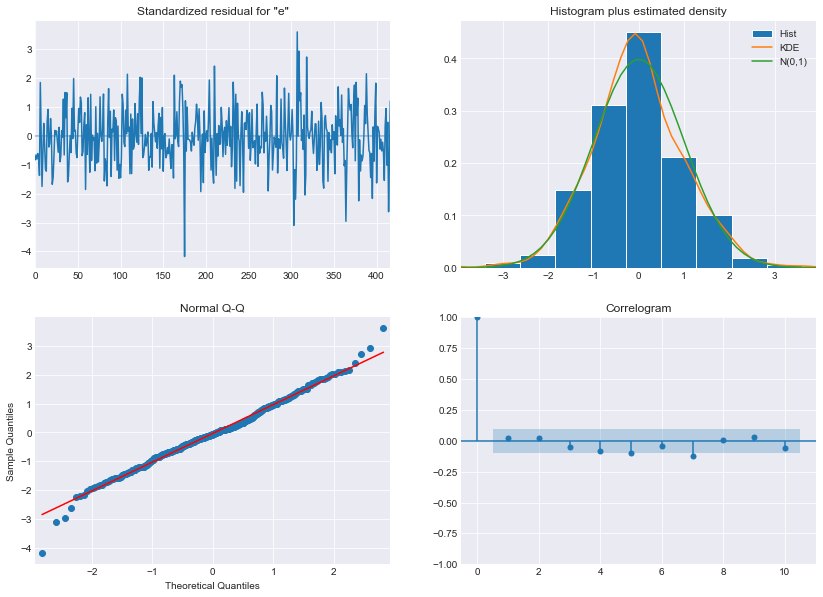

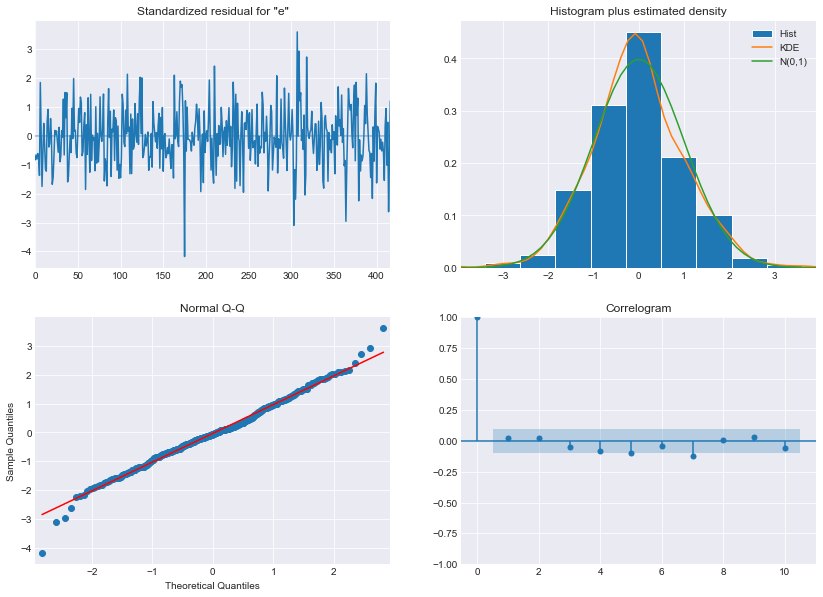

In [17]:
results.plot_diagnostics(figsize=(14,10))

In [18]:
type(forecast_values.predicted_mean)

pandas.core.series.Series

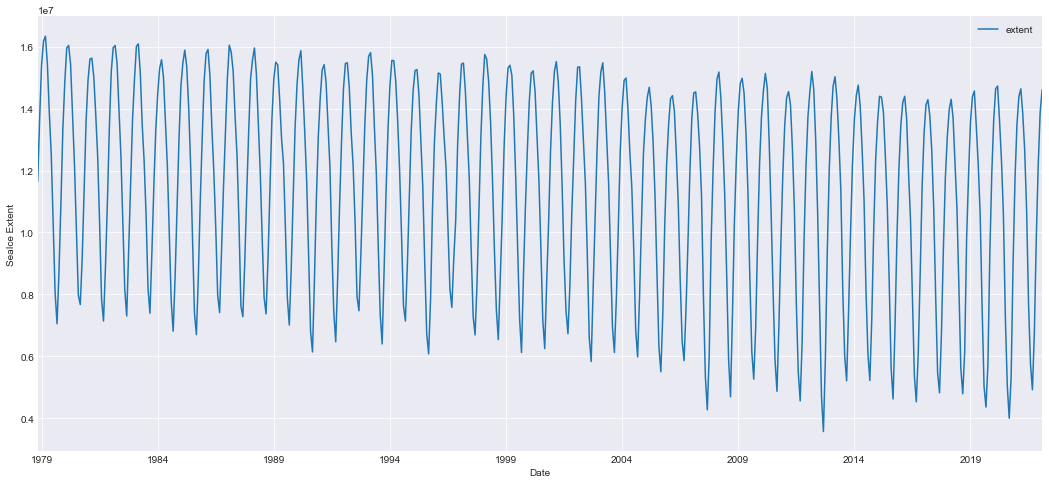

In [19]:
ax = df_month_mod.plot(x='date', y='extent')
#the following lines doesn't work like in the modelling notebook???
#forecast_values.predicted_mean.plot(ax=ax, label='predicted')

#ax.fill_between(forecast_ci.index,
#                forecast_ci.iloc[:, 0],
#                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()

## Modeling of the different regions

#### Hudson Bay

In [20]:
df_hb_mod = pd.read_csv('../data/HudsonBay.csv')
df_hb_mod['date'] = pd.to_datetime(df_hb_mod['date'])
df_hb_mod.head()

,date,HB_extent
0,2006-01-01,1.260715
1,2006-01-02,1.260715
2,2006-01-03,1.260779
3,2006-01-04,1.260779
4,2006-01-05,1.260779


In [21]:
#filling missing dates
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates_hb = pd.DataFrame(pd.date_range(df_hb_mod['date'].min(), df_hb_mod['date'].max()), columns=['date'])

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_hb_mod = all_dates_hb.merge(right=df_hb_mod, how='left', on='date')

# filling the NaN values with the values of the day before
df_hb_mod.fillna(method='ffill', inplace=True)
df_hb_mod = df_hb_mod.reset_index(drop=True)

In [22]:
# Extract additional features from timestamp column
df_hb_mod = df_hb_mod.assign(
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear
)

In [23]:
#for monthly data groupby year and months and calculate mean
extent_month=df_hb_mod.groupby(['year', 'month'])['HB_extent'].mean()
df_monthlyextent = extent_month.to_frame()
df_monthlyextent.head()

HB_extent
year month           
2006 1       1.260775
     2       1.258036
     3       1.240272
     4       1.229156
     5       1.073563

In [24]:
#create a new date column with the first of each month
months = []
years = []

for i, x in enumerate(df_monthlyextent['HB_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent['year'] = years
df_monthlyextent['month'] = months
df_monthlyextent['day'] = 1
df_monthlyextent.reset_index(drop=True, inplace=True)
df_monthlyextent.head()

,HB_extent,year,month,day
0,1.260775,2006,1,1
1,1.258036,2006,2,1
2,1.240272,2006,3,1
3,1.229156,2006,4,1
4,1.073563,2006,5,1


In [25]:
df_monthlyextent['date'] = pd.to_datetime(df_monthlyextent[['year', 'month', 'day']])
df_monthlyextent.set_index('date', drop=False, inplace=True)
df_monthlyextent.head()

,HB_extent,year,month,day,date
date,,,,,
2006-01-01,1.260775,2006,1,1,2006-01-01
2006-02-01,1.258036,2006,2,1,2006-02-01
2006-03-01,1.240272,2006,3,1,2006-03-01
2006-04-01,1.229156,2006,4,1,2006-04-01
2006-05-01,1.073563,2006,5,1,2006-05-01


In [26]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent = df_monthlyextent['HB_extent']

train_size_monthly = int(len(X_monthlyextent)*0.8038)
train_monthlyextent, test_monthlyextent = X_monthlyextent[1:train_size_monthly], X_monthlyextent[train_size_monthly:]
print('Observations: %d' % (len(X_monthlyextent)))
print('Training Observations: %d' % (len(train_monthlyextent)))
print('Testing Observations: %d' % (len(test_monthlyextent)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [27]:
#grid search for Hudson Bay 
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod1 = sm.tsa.statespace.SARIMAX(X_monthlyextent,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod1.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.57279D-01    |proj g|=  7.75115D-01

At iterate    5    f= -8.58599D-01    |proj g|=  3.97878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5     17      1     0     0   3.979D-04  -8.586D-01
  F = -0.85859871567507517   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -9.08113D-01    |proj g|=  8.58856D-01

At iterate   10    f= -9.10704D-01    |proj g|=  1.26629D-02

At iterate   15    f= -9.10909D-01    |proj g|=  9.79039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     35      1     0     0   1.251D-04  -9.109D-01
  F = -0.91094648820320778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:-349.269130399251
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-376.93509320030535
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.98967D-01    |proj g|=  1.39518D+00


 This problem is unconstrained.



At iterate    5    f= -9.09600D-01    |proj g|=  1.02777D+00

At iterate   10    f= -9.15610D-01    |proj g|=  1.03626D-01

At iterate   15    f= -9.16422D-01    |proj g|=  1.88740D-02

At iterate   20    f= -9.16457D-01    |proj g|=  7.48447D-02

At iterate   25    f= -9.17165D-01    |proj g|=  5.11845D-03

At iterate   30    f= -9.17174D-01    |proj g|=  3.20472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     41      1     0     0   9.680D-05  -9.172D-01
  F = -0.91717431979790931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:-349.697984721

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:-320.5397632617369
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.53037D-01    |proj g|=  4.75375D-01

At iterate    5    f= -8.57011D-01    |proj g|=  9.69660D-01

At iterate   10    f= -8.72197D-01    |proj g|=  5.66645D-01


 This problem is unconstrained.



At iterate   15    f= -8.98622D-01    |proj g|=  1.30566D+00

At iterate   20    f= -9.11385D-01    |proj g|=  1.15508D-02

At iterate   25    f= -9.11905D-01    |proj g|=  6.41324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   2.711D-04  -9.119D-01
  F = -0.91190542987079393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:-347.6431176496096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f= -8.89801D-01    |proj g|=  8.54053D-01

At iterate   10    f= -8.99100D-01    |proj g|=  1.98823D-01

At iterate   15    f= -9.04462D-01    |proj g|=  2.30490D-01

At iterate   20    f= -9.05528D-01    |proj g|=  1.87868D-02

At iterate   25    f= -9.06412D-01    |proj g|=  1.58060D-01

At iterate   30    f= -9.09798D-01    |proj g|=  4.69680D-02

At iterate   35    f= -9.09841D-01    |proj g|=  1.56310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   1.563D-04  -9.098D-01
  F = -0.90984098799886559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     34      1     0     0   3.485D-04  -1.043D+00
  F =  -1.0430620989817776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-400.79421860289324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.91702D-01    |proj g|=  2.91100D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.25487D-01    |proj g|=  9.50699D-01

At iterate   10    f= -9.40831D-01    |proj g|=  3.73301D-01

At iterate   15    f= -9.58221D-01    |proj g|=  2.01764D+00

At iterate   20    f= -9.67947D-01    |proj g|=  4.10778D-03

At iterate   25    f= -9.67989D-01    |proj g|=  1.13064D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      2     0     0   1.522D-05  -9.680D-01
  F = -0.96799534622036398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:-369.51818502594193
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.09728D-01    |proj g|=  1.39389D+00

At iterate    5    f= -9.15647D-01    |proj g|=  3.62953D-01

At iterate   10    f= -9.41211D-01    |proj g|=  1.59782D+00

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.01600D+00    |proj g|=  4.79630D+00

At iterate   15    f= -1.03750D+00    |proj g|=  4.48862D-01

At iterate   20    f= -1.04812D+00    |proj g|=  5.62652D-02

At iterate   25    f= -1.04832D+00    |proj g|=  1.50961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   9.868D-05  -1.048D+00
  F =  -1.0483215343460710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-400.8453983949677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate    5    f= -9.54416D-01    |proj g|=  4.26918D-01

At iterate   10    f= -9.78879D-01    |proj g|=  3.71496D-02

At iterate   15    f= -9.82129D-01    |proj g|=  1.24798D-01

At iterate   20    f= -9.83659D-01    |proj g|=  5.20855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.769D-04  -9.837D-01
  F = -0.98365890326853977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:-373.6269722747305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   5.495D-06  -8.980D-01
  F = -0.89802604718851087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:-342.2301584035192
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.71229D-01    |proj g|=  1.88791D+00

At iterate    5    f= -8.82634D-01    |proj g|=  1.99043D-01

At iterate   10    f= -9.06635D-01    |proj g|=  1.70509D+00


 This problem is unconstrained.



At iterate   15    f= -9.28182D-01    |proj g|=  1.78941D+00

At iterate   20    f= -9.58015D-01    |proj g|=  2.38021D-01

At iterate   25    f= -9.69926D-01    |proj g|=  7.34018D-01

At iterate   30    f= -9.75463D-01    |proj g|=  4.89895D-04

At iterate   35    f= -9.75463D-01    |proj g|=  1.26811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     43      1     0     0   6.592D-06  -9.755D-01
  F = -0.97546292587087302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:-370.4305410896405
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -9.36987D-01    |proj g|=  3.23922D-01

At iterate   10    f= -9.61677D-01    |proj g|=  6.22720D-02

At iterate   15    f= -9.63721D-01    |proj g|=  1.33853D-02

At iterate   20    f= -9.65499D-01    |proj g|=  2.51159D-02

At iterate   25    f= -9.66473D-01    |proj g|=  3.35678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   2.409D-04  -9.665D-01
  F = -0.96647423450480241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:-364.9249514568729
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.10219D+00    |proj g|=  6.06638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   6.680D-04  -1.102D+00
  F =  -1.1021902080784212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:-421.8541811505843
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.74651D-01    |proj g|=  3.53299D+00


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     14      1     0     0   3.533D+00  -9.747D-01
  F = -0.97465123609902082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:-370.1139820786181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00416D+00    |proj g|=  1.87574D+00

At iterate    5    f= -1.01218D+00    |proj g|=  4.71851D-02

At iterate   10    f= -1.01290D+00    |proj g|=  8.23641D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.03847D+00    |proj g|=  5.39860D-01

At iterate   10    f= -1.08007D+00    |proj g|=  3.49243D+00

At iterate   15    f= -1.10649D+00    |proj g|=  2.03179D-02

At iterate   20    f= -1.10690D+00    |proj g|=  2.79025D-03

At iterate   25    f= -1.10690D+00    |proj g|=  1.95679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   3.258D-05  -1.107D+00
  F =  -1.1069007591690643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:-421.69129607593504
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     17      1     0     0   3.535D+00  -9.793D-01
  F = -0.97928323565433006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:-369.92046190518874
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.51898D-01    |proj g|=  2.19567D+00

At iterate    5    f= -9.64385D-01    |proj g|=  2.10361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     15      1     0     0   3.183D-05  -9.644D-01
  F = -0.96439056254610145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:-366.11231939297954
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.65716D-01    |proj g|=  2.56941D+00

At iterate    5    f= -9.84539D-01    |proj g|=  5.24201D-01


 This problem is unconstrained.



At iterate   10    f= -1.00212D+00    |proj g|=  2.16973D-01

At iterate   15    f= -1.02544D+00    |proj g|=  1.83855D+00

At iterate   20    f= -1.03263D+00    |proj g|=  2.54161D-01

At iterate   25    f= -1.04032D+00    |proj g|=  8.37054D-01

At iterate   30    f= -1.04165D+00    |proj g|=  2.05187D-02

At iterate   35    f= -1.04174D+00    |proj g|=  6.22843D-02

At iterate   40    f= -1.04179D+00    |proj g|=  3.47694D-03

At iterate   45    f= -1.04179D+00    |proj g|=  9.24412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53      1     0     0   1.889D-03  -1.042D+00
  F =  -1.04178989216

 This problem is unconstrained.



At iterate    5    f= -1.00718D+00    |proj g|=  1.09361D+00

At iterate   10    f= -1.01170D+00    |proj g|=  4.25048D-01

At iterate   15    f= -1.01733D+00    |proj g|=  3.00106D-02

At iterate   20    f= -1.01810D+00    |proj g|=  2.03043D-02

At iterate   25    f= -1.01847D+00    |proj g|=  1.81160D-01

At iterate   30    f= -1.01887D+00    |proj g|=  3.15572D-02

At iterate   35    f= -1.02111D+00    |proj g|=  6.44885D-02

At iterate   40    f= -1.02357D+00    |proj g|=  2.66850D-03

At iterate   45    f= -1.02358D+00    |proj g|=  1.46209D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49    100      2     0     0   1.631D-04  -1.024D+00
  F =  -1.0235781001019419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:-385.19545903975734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.71887D-01    |proj g|=  1.12619D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.75369D-01    |proj g|=  2.90347D+00


 This problem is unconstrained.



At iterate    5    f= -9.16295D-01    |proj g|=  9.97200D-01

At iterate   10    f= -9.18787D-01    |proj g|=  1.01923D-02

At iterate   15    f= -9.18893D-01    |proj g|=  1.14992D-02

At iterate   20    f= -9.18937D-01    |proj g|=  2.21664D-03

At iterate   25    f= -9.18940D-01    |proj g|=  8.21718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   8.217D-05  -9.189D-01
  F = -0.91894035635386839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:-350.3867389780087
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -9.85605D-01    |proj g|=  3.53207D-01

At iterate   20    f= -9.91143D-01    |proj g|=  7.97943D-04

At iterate   25    f= -9.91144D-01    |proj g|=  2.61928D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.619D-05  -9.911D-01
  F = -0.99114425022656072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-378.5462575883587
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f= -9.12961D-01    |proj g|=  6.10771D-01

At iterate   10    f= -9.23608D-01    |proj g|=  3.56072D-02

At iterate   15    f= -9.24234D-01    |proj g|=  2.66587D-01

At iterate   20    f= -9.24792D-01    |proj g|=  1.01142D-02

At iterate   25    f= -9.25022D-01    |proj g|=  2.03073D-01

At iterate   30    f= -9.25863D-01    |proj g|=  3.75837D-02

At iterate   35    f= -9.25978D-01    |proj g|=  5.68901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     47      1     0     0   9.180D-05  -9.260D-01
  F = -0.92597900796126442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:-318.34927228763013
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.40796D-01    |proj g|=  1.81513D+00

At iterate    5    f= -8.51773D-01    |proj g|=  8.03798D-02

At iterate   10    f= -8.60773D-01    |proj g|=  9.63995D-01


 This problem is unconstrained.



At iterate   15    f= -8.73572D-01    |proj g|=  1.53502D+00

At iterate   20    f= -9.10996D-01    |proj g|=  2.73134D-01

At iterate   25    f= -9.11823D-01    |proj g|=  8.70915D-02

At iterate   30    f= -9.11978D-01    |proj g|=  5.03440D-02

At iterate   35    f= -9.12000D-01    |proj g|=  1.13769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   1.359D-03  -9.120D-01
  F = -0.91200045968616472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:-345.6801792776042
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -9.11643D-01    |proj g|=  1.83341D-01

At iterate   10    f= -9.12930D-01    |proj g|=  1.81787D-01

At iterate   15    f= -9.15404D-01    |proj g|=  5.65215D-01

At iterate   20    f= -9.16568D-01    |proj g|=  5.46996D-02

At iterate   25    f= -9.17031D-01    |proj g|=  4.17841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     37      1     0     0   1.151D-04  -9.170D-01
  F = -0.91703067914564329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:-345.6419648668009
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.09019D+00    |proj g|=  6.64506D-02

At iterate   20    f= -1.09033D+00    |proj g|=  3.12371D-02

At iterate   25    f= -1.09035D+00    |proj g|=  5.35494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     37      1     0     0   3.397D-04  -1.090D+00
  F =  -1.0903488884409047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-417.23606649195284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate    5    f= -9.81477D-01    |proj g|=  4.57818D+00

At iterate   10    f= -1.00434D+00    |proj g|=  4.05333D-01

At iterate   15    f= -1.01216D+00    |proj g|=  1.41412D-01

At iterate   20    f= -1.01283D+00    |proj g|=  1.21026D-02

At iterate   25    f= -1.01289D+00    |proj g|=  3.29877D-02

At iterate   30    f= -1.01293D+00    |proj g|=  7.99795D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     0     0   6.567D-05  -1.013D+00
  F =  -1.0129251191564532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:-385.040796471

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.04462D+00    |proj g|=  1.35876D+00

At iterate   10    f= -1.06219D+00    |proj g|=  7.79620D-01

At iterate   15    f= -1.09396D+00    |proj g|=  1.97110D-02

At iterate   20    f= -1.09424D+00    |proj g|=  4.10944D-02

At iterate   25    f= -1.09432D+00    |proj g|=  1.57812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   1.578D-04  -1.094D+00
  F =  -1.0943196056467379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-416.7846462022278
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -9.83171D-01    |proj g|=  4.79998D+00

At iterate   10    f= -1.00885D+00    |proj g|=  3.27428D-01

At iterate   15    f= -1.02041D+00    |proj g|=  2.36105D-02

At iterate   20    f= -1.02142D+00    |proj g|=  1.37563D-02

At iterate   25    f= -1.02187D+00    |proj g|=  2.50732D-01

At iterate   30    f= -1.02359D+00    |proj g|=  1.75598D-02

At iterate   35    f= -1.02381D+00    |proj g|=  8.39491D-04

At iterate   40    f= -1.02381D+00    |proj g|=  1.47435D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     50      1     0     0   1.474D-04  -1.024D+00
  F =  -1.02380681127

 This problem is unconstrained.



At iterate   10    f= -9.32172D-01    |proj g|=  1.02930D+00

At iterate   15    f= -9.40788D-01    |proj g|=  2.24109D-02

At iterate   20    f= -9.40999D-01    |proj g|=  9.16492D-03

At iterate   25    f= -9.41012D-01    |proj g|=  2.55602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   3.227D-05  -9.410D-01
  F = -0.94101275339203461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:-356.9949738228935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate    5    f= -9.58854D-01    |proj g|=  7.44804D-01

At iterate   10    f= -9.70370D-01    |proj g|=  5.18722D-01

At iterate   15    f= -1.00902D+00    |proj g|=  7.49846D-02

At iterate   20    f= -1.01423D+00    |proj g|=  4.24282D-02

At iterate   25    f= -1.01481D+00    |proj g|=  1.03104D-02

At iterate   30    f= -1.01497D+00    |proj g|=  1.06675D-02

At iterate   35    f= -1.01497D+00    |proj g|=  3.61645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     60      1     0     0   2.295D-05  -1.015D+00
  F =  -1.0149724084454281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:-383.839239293717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.77649D-01    |proj g|=  3.66902D+00


 This problem is unconstrained.



At iterate    5    f= -9.47780D-01    |proj g|=  3.36593D+00

At iterate   10    f= -9.96434D-01    |proj g|=  5.92450D-01

At iterate   15    f= -1.00646D+00    |proj g|=  9.97683D-02

At iterate   20    f= -1.00800D+00    |proj g|=  6.30464D-02

At iterate   25    f= -1.00857D+00    |proj g|=  4.31357D-01

At iterate   30    f= -1.01141D+00    |proj g|=  8.23883D-02

At iterate   35    f= -1.01177D+00    |proj g|=  1.22721D-02

At iterate   40    f= -1.01200D+00    |proj g|=  2.99582D-03

At iterate   45    f= -1.01200D+00    |proj g|=  2.82806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     65   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.09303D+00    |proj g|=  2.71768D-01

At iterate   15    f= -1.10184D+00    |proj g|=  3.05685D-01

At iterate   20    f= -1.10203D+00    |proj g|=  1.15131D-02

At iterate   25    f= -1.10228D+00    |proj g|=  5.64535D-03

At iterate   30    f= -1.10231D+00    |proj g|=  2.75424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     48      1     0     0   1.614D-04  -1.102D+00
  F =  -1.1023109370002182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:-419.9012654300851
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -1.01852D+00    |proj g|=  6.22666D-01

At iterate   10    f= -1.02194D+00    |proj g|=  8.42578D-02

At iterate   15    f= -1.02218D+00    |proj g|=  1.92081D-01

At iterate   20    f= -1.02249D+00    |proj g|=  7.27780D-02

At iterate   25    f= -1.02269D+00    |proj g|=  4.79359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     43      1     0     0   3.698D-04  -1.023D+00
  F =  -1.0226906847734838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:-386.84936706165865
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   30    f= -1.00536D+00    |proj g|=  7.20415D-03

At iterate   35    f= -1.00540D+00    |proj g|=  3.09460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   2.382D-05  -1.005D+00
  F =  -1.0053969921257067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:-382.1048269290256
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01675D+00    |proj g|=  2.67172D+00

At iterate   

 This problem is unconstrained.



At iterate   15    f= -1.08306D+00    |proj g|=  2.43734D+00

At iterate   20    f= -1.10618D+00    |proj g|=  2.59890D-02

At iterate   25    f= -1.10691D+00    |proj g|=  1.56719D-02

At iterate   30    f= -1.10696D+00    |proj g|=  6.42125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     42      1     0     0   2.731D-05  -1.107D+00
  F =  -1.1069814975407990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:-419.7227840409116
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

 This problem is unconstrained.



At iterate    5    f= -1.01663D+00    |proj g|=  8.23843D-01

At iterate   10    f= -1.02680D+00    |proj g|=  5.80373D-01

At iterate   15    f= -1.02832D+00    |proj g|=  1.09972D-01

At iterate   20    f= -1.02894D+00    |proj g|=  1.35629D-01

At iterate   25    f= -1.02933D+00    |proj g|=  1.23776D-01

At iterate   30    f= -1.03115D+00    |proj g|=  1.17565D-02

At iterate   35    f= -1.03118D+00    |proj g|=  1.73692D-03

At iterate   40    f= -1.03122D+00    |proj g|=  4.83398D-03

At iterate   45    f= -1.03122D+00    |proj g|=  3.94570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     62   

 This problem is unconstrained.



At iterate   10    f= -9.56815D-01    |proj g|=  1.20388D-02

At iterate   15    f= -9.56880D-01    |proj g|=  5.52260D-02

At iterate   20    f= -9.56911D-01    |proj g|=  1.43202D-02

At iterate   25    f= -9.56945D-01    |proj g|=  4.88562D-03

At iterate   30    f= -9.56964D-01    |proj g|=  3.57743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     43      1     0     0   1.190D-04  -9.570D-01
  F = -0.95696664380624674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:-361.21699108443624
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   10    f= -9.82107D-01    |proj g|=  5.33129D-01

At iterate   15    f= -1.00266D+00    |proj g|=  2.32416D+00

At iterate   20    f= -1.03308D+00    |proj g|=  3.40128D-01

At iterate   25    f= -1.03459D+00    |proj g|=  3.01375D-02

At iterate   30    f= -1.03486D+00    |proj g|=  2.22819D-02

At iterate   35    f= -1.03486D+00    |proj g|=  8.14674D-04

At iterate   40    f= -1.03486D+00    |proj g|=  5.10256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     53      1     0     0   2.698D-04  -1.035D+00
  F =  -1.0348616579205090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.00069D+00    |proj g|=  7.08800D-01

At iterate   10    f= -1.01564D+00    |proj g|=  1.08365D-01

At iterate   15    f= -1.01871D+00    |proj g|=  1.34795D-01

At iterate   20    f= -1.01886D+00    |proj g|=  1.55947D-01

At iterate   25    f= -1.02113D+00    |proj g|=  2.84861D-02

At iterate   30    f= -1.02305D+00    |proj g|=  3.38735D-02

At iterate   35    f= -1.02355D+00    |proj g|=  7.94709D-03

At iterate   40    f= -1.02364D+00    |proj g|=  7.98754D-03

At iterate   45    f= -1.02379D+00    |proj g|=  1.50465D-02

At iterate   50    f= -1.02379D+00    |proj g|=  2.89326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f= -1.04579D+00    |proj g|=  1.60968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     42      2     0     0   1.610D-03  -1.046D+00
  F =  -1.0457875887685673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:-399.8571596197412
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.34054D-01    |proj g|=  3.12348D+00

At iterate    5    f= -9.73576D-01    |proj g|=  8.02130D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.02644D+00    |proj g|=  1.51231D-01

At iterate   15    f= -1.04374D+00    |proj g|=  3.14738D-02

At iterate   20    f= -1.04375D+00    |proj g|=  9.22389D-03

At iterate   25    f= -1.04917D+00    |proj g|=  6.62495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   3.246D-04  -1.049D+00
  F =  -1.0491683998501966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:-399.1756759415767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate    5    f= -9.72178D-01    |proj g|=  8.70228D-01

At iterate   10    f= -9.79839D-01    |proj g|=  1.97502D-01

At iterate   15    f= -9.80130D-01    |proj g|=  1.11415D-02

At iterate   20    f= -9.80452D-01    |proj g|=  3.28670D-01

At iterate   25    f= -9.80953D-01    |proj g|=  3.11896D-03

At iterate   30    f= -9.80959D-01    |proj g|=  8.80828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     49      1     0     0   1.546D-03  -9.810D-01
  F = -0.98095925238702431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:-370.574108430

 This problem is unconstrained.


ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:-335.88836892766267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.91315D-01    |proj g|=  1.88649D+00

At iterate    5    f= -9.04664D-01    |proj g|=  7.30617D-01


 This problem is unconstrained.



At iterate   10    f= -9.14041D-01    |proj g|=  4.30748D-01

At iterate   15    f= -9.44315D-01    |proj g|=  1.74763D+00

At iterate   20    f= -9.52345D-01    |proj g|=  3.65798D-01

At iterate   25    f= -9.59471D-01    |proj g|=  2.43216D-01

At iterate   30    f= -9.60024D-01    |proj g|=  2.85050D-02

At iterate   35    f= -9.60045D-01    |proj g|=  2.22197D-03

At iterate   40    f= -9.60046D-01    |proj g|=  9.41109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     54      1     0     0   5.637D-05  -9.600D-01
  F = -0.96004561497161578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -9.47513D-01    |proj g|=  1.00368D+00

At iterate   10    f= -9.60027D-01    |proj g|=  1.47097D-01

At iterate   15    f= -9.60655D-01    |proj g|=  3.46882D-01

At iterate   20    f= -9.61159D-01    |proj g|=  3.77620D-02

At iterate   25    f= -9.61810D-01    |proj g|=  3.22140D-01

At iterate   30    f= -9.64882D-01    |proj g|=  2.05824D-02

At iterate   35    f= -9.65387D-01    |proj g|=  1.66592D-01

At iterate   40    f= -9.65629D-01    |proj g|=  1.92120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     58      1     0     0   3.379D-04  -9.656D-01
  F = -0.965629395696

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.09256D+00    |proj g|=  2.65681D-01

At iterate   10    f= -1.12070D+00    |proj g|=  9.59599D-01

At iterate   15    f= -1.12672D+00    |proj g|=  2.25303D-02

At iterate   20    f= -1.12686D+00    |proj g|=  7.23439D-03

At iterate   25    f= -1.12686D+00    |proj g|=  1.13356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.082D-03  -1.127D+00
  F =  -1.1268621524867684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-429.4762394698397
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -1.03081D+00    |proj g|=  1.04845D+00

At iterate   10    f= -1.04033D+00    |proj g|=  1.33931D-01

At iterate   15    f= -1.04269D+00    |proj g|=  3.35160D-01

At iterate   20    f= -1.04483D+00    |proj g|=  2.95793D-02

At iterate   25    f= -1.04501D+00    |proj g|=  3.04340D-03

At iterate   30    f= -1.04502D+00    |proj g|=  9.29610D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     62      2     0     0   1.783D-04  -1.045D+00
  F =  -1.0450205203785770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-395.55800294764504
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.92707D-01    |proj g|=  1.95896D+00

At iterate    5    f= -1.00415D+00    |proj g|=  2.60106D-01

At iterate   10    f= -1.00805D+00    |proj g|=  6.91490D-02

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02899D+00    |proj g|=  2.94267D+00

At iterate    5    f= -1.10997D+00    |proj g|=  8.66754D-01

At iterate   10    f= -1.13351D+00    |proj g|=  1.72864D-01

At iterate   15    f= -1.13407D+00    |proj g|=  1.71754D-01

At iterate   20    f= -1.13452D+00    |proj g|=  1.96857D-03

At iterate   25    f= -1.13452D+00    |proj g|=  3.21426D-03

At iterate   30    f= -1.13452D+00    |proj g|=  1.18261D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     84      2     0     0   1.183D-03  -1.135D+00
  F =  -1.1345184775462300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-430.46220624302975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.88509D-01    |proj g|=  3.74366D+00


 This problem is unconstrained.



At iterate    5    f= -1.03296D+00    |proj g|=  7.80194D-01

At iterate   10    f= -1.04844D+00    |proj g|=  2.03783D-01

At iterate   15    f= -1.04928D+00    |proj g|=  3.46739D-01

At iterate   20    f= -1.04963D+00    |proj g|=  9.06543D-03

At iterate   25    f= -1.05088D+00    |proj g|=  3.84247D-02

At iterate   30    f= -1.05171D+00    |proj g|=  6.84893D-02

At iterate   35    f= -1.05180D+00    |proj g|=  1.57619D-02

At iterate   40    f= -1.05181D+00    |proj g|=  2.46759D-03

At iterate   45    f= -1.05181D+00    |proj g|=  5.88913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     56   

 This problem is unconstrained.



At iterate   15    f= -9.59764D-01    |proj g|=  2.11702D-02

At iterate   20    f= -9.60054D-01    |proj g|=  1.73106D-03

At iterate   25    f= -9.60054D-01    |proj g|=  1.81331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   5.286D-04  -9.601D-01
  F = -0.96005427174476399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:-362.42116598045794
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   10    f= -1.00232D+00    |proj g|=  1.58303D+00

At iterate   15    f= -1.03472D+00    |proj g|=  6.33926D-01

At iterate   20    f= -1.03693D+00    |proj g|=  3.06215D-01

At iterate   25    f= -1.04057D+00    |proj g|=  1.44976D-02

At iterate   30    f= -1.04088D+00    |proj g|=  7.29986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     46      1     0     0   2.068D-04  -1.041D+00
  F =  -1.0408802822931895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:-391.94331009434393
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate    5    f= -1.01858D+00    |proj g|=  8.99770D-01

At iterate   10    f= -1.02975D+00    |proj g|=  5.25307D-01

At iterate   15    f= -1.03696D+00    |proj g|=  7.44902D-02

At iterate   20    f= -1.03889D+00    |proj g|=  5.04315D-01

At iterate   25    f= -1.03995D+00    |proj g|=  1.98942D-01

At iterate   30    f= -1.04074D+00    |proj g|=  1.51098D-01

At iterate   35    f= -1.04415D+00    |proj g|=  1.19953D-01

At iterate   40    f= -1.04504D+00    |proj g|=  3.71389D-02

At iterate   45    f= -1.04510D+00    |proj g|=  2.45360D-02

At iterate   50    f= -1.04511D+00    |proj g|=  4.45570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.08778D+00    |proj g|=  5.85361D-01

At iterate   10    f= -1.11415D+00    |proj g|=  1.72830D-01

At iterate   15    f= -1.11681D+00    |proj g|=  1.36993D-02

At iterate   20    f= -1.11995D+00    |proj g|=  5.29754D-01

At iterate   25    f= -1.12361D+00    |proj g|=  8.50818D-02

At iterate   30    f= -1.12905D+00    |proj g|=  2.33263D-02

At iterate   35    f= -1.12987D+00    |proj g|=  8.47066D-03

At iterate   40    f= -1.12987D+00    |proj g|=  4.13322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     70      1     0     0   1.513D-04  -1.130D+00
  F =  -1.12987492282

 This problem is unconstrained.



At iterate    5    f= -1.02324D+00    |proj g|=  8.67792D-01

At iterate   10    f= -1.03170D+00    |proj g|=  3.65093D-02

At iterate   15    f= -1.03260D+00    |proj g|=  3.44794D-01

At iterate   20    f= -1.03369D+00    |proj g|=  8.60073D-02

At iterate   25    f= -1.03464D+00    |proj g|=  5.04453D-02

At iterate   30    f= -1.03657D+00    |proj g|=  9.88089D-02

At iterate   35    f= -1.03834D+00    |proj g|=  2.71075D-01

At iterate   40    f= -1.04144D+00    |proj g|=  1.57205D-02

At iterate   45    f= -1.04176D+00    |proj g|=  2.92075D-02

At iterate   50    f= -1.04177D+00    |proj g|=  3.25404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f= -1.01347D+00    |proj g|=  7.54795D-02

At iterate   40    f= -1.01353D+00    |proj g|=  8.96416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     58      1     0     0   4.119D-04  -1.014D+00
  F =  -1.0135266856258316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:-383.2754073940743
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02760D+00    |proj g|=  2.77838D+00


 This problem is unconstrained.



At iterate    5    f= -1.05100D+00    |proj g|=  7.48146D-01

At iterate   10    f= -1.10093D+00    |proj g|=  2.35179D+00

At iterate   15    f= -1.10764D+00    |proj g|=  1.24466D+00

At iterate   20    f= -1.11690D+00    |proj g|=  3.36905D-02

At iterate   25    f= -1.11925D+00    |proj g|=  8.36580D-02

At iterate   30    f= -1.12238D+00    |proj g|=  3.81315D+01
  ys=-1.856E-01  -gs= 1.264E-04 BFGS update SKIPPED

At iterate   35    f= -1.12351D+00    |proj g|=  8.22081D-01

At iterate   40    f= -1.12355D+00    |proj g|=  1.28025D+00

At iterate   45    f= -1.12379D+00    |proj g|=  4.09551D+00

At iterate   50    f= -1.12394D+00    |proj g|=  1.38235D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f= -1.02683D+00    |proj g|=  5.87008D-01

At iterate   10    f= -1.03839D+00    |proj g|=  7.03842D-02

At iterate   15    f= -1.03890D+00    |proj g|=  2.24485D-01

At iterate   20    f= -1.03973D+00    |proj g|=  1.41751D-01

At iterate   25    f= -1.04006D+00    |proj g|=  9.25790D-02

At iterate   30    f= -1.04254D+00    |proj g|=  1.87365D-01

At iterate   35    f= -1.04658D+00    |proj g|=  7.20235D-02

At iterate   40    f= -1.04723D+00    |proj g|=  6.17050D-02

At iterate   45    f= -1.04966D+00    |proj g|=  6.84609D-02

At iterate   50    f= -1.05021D+00    |proj g|=  3.35437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -9.58857D-01    |proj g|=  9.08798D-02

At iterate   15    f= -9.59148D-01    |proj g|=  1.15561D-01

At iterate   20    f= -9.60997D-01    |proj g|=  1.23795D-01

At iterate   25    f= -9.63289D-01    |proj g|=  2.48019D-01

At iterate   30    f= -9.66454D-01    |proj g|=  1.54871D-01

At iterate   35    f= -9.66609D-01    |proj g|=  2.39824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     51      1     0     0   3.989D-05  -9.666D-01
  F = -0.96660887403705009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:-362.977460874

 This problem is unconstrained.


At iterate    5    f= -9.78489D-01    |proj g|=  6.33214D-01

At iterate   10    f= -1.02450D+00    |proj g|=  8.38670D-01

At iterate   15    f= -1.03969D+00    |proj g|=  1.58606D-01

At iterate   20    f= -1.04073D+00    |proj g|=  5.27975D-02

At iterate   25    f= -1.04112D+00    |proj g|=  1.11030D-02

At iterate   30    f= -1.04140D+00    |proj g|=  9.85179D-03

At iterate   35    f= -1.04152D+00    |proj g|=  9.05233D-04

At iterate   40    f= -1.04152D+00    |proj g|=  2.04487D-03

At iterate   45    f= -1.04152D+00    |proj g|=  6.66040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     69    

 This problem is unconstrained.



At iterate    5    f= -1.01294D+00    |proj g|=  9.23272D-01

At iterate   10    f= -1.02542D+00    |proj g|=  3.34128D-01

At iterate   15    f= -1.02971D+00    |proj g|=  4.49492D-02

At iterate   20    f= -1.03086D+00    |proj g|=  1.62588D-01

At iterate   25    f= -1.03631D+00    |proj g|=  5.70575D-01

At iterate   30    f= -1.04022D+00    |proj g|=  6.45761D+00
  ys=-2.655E-02  -gs= 3.512E-04 BFGS update SKIPPED

At iterate   35    f= -1.04125D+00    |proj g|=  1.02895D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     66      1     1     0   2.524D-02  -1.041D+00
  F =  -1.0412716278662690     

In [28]:
#SARIMA(2, 1, 2)x(2, 1, 2, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: -0.946161
         Iterations: 9
         Function evaluations: 991
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3608      0.571      0.632      0.527      -0.757       1.479
ar.L2         -0.2564      0.175     -1.463      0.143      -0.600       0.087
ma.L1         -0.8452      0.615     -1.375      0.169      -2.050       0.360
ma.L2          0.0320      0.536      0.060      0.952      -1.018       1.082
ar.S.L12       0.0628      0.195      0.323      0.747      -0.319       0.445
ar.S.L24      -0.3554      0.109     -3.256      0.001      -0.569      -0.141
ma.S.L12      -0.7377      0.194     -3.798      0.000      -1.118      -0.357
ma.S.L24       0.0545      0.215      0.253      0.800      -0.368       0.477
sigma2         0.0043      0.001      8.082      0.000       0.003     

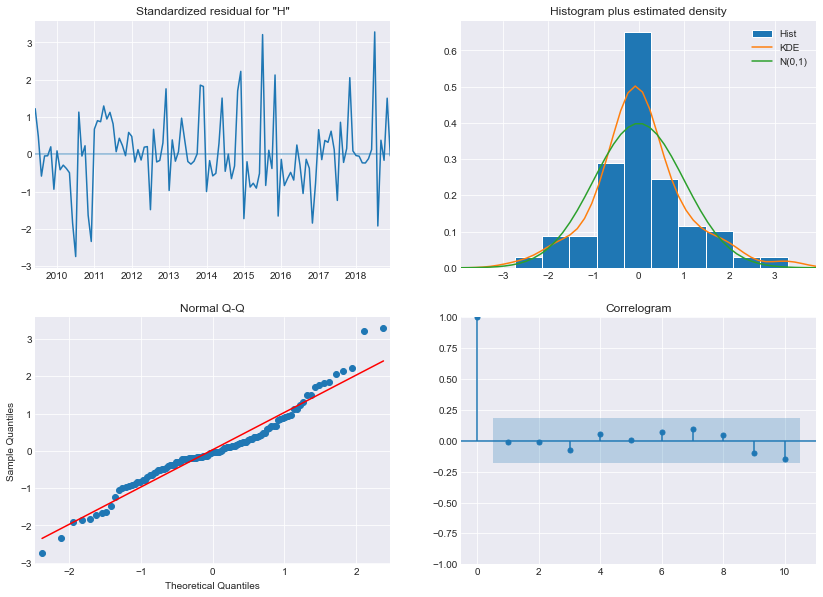

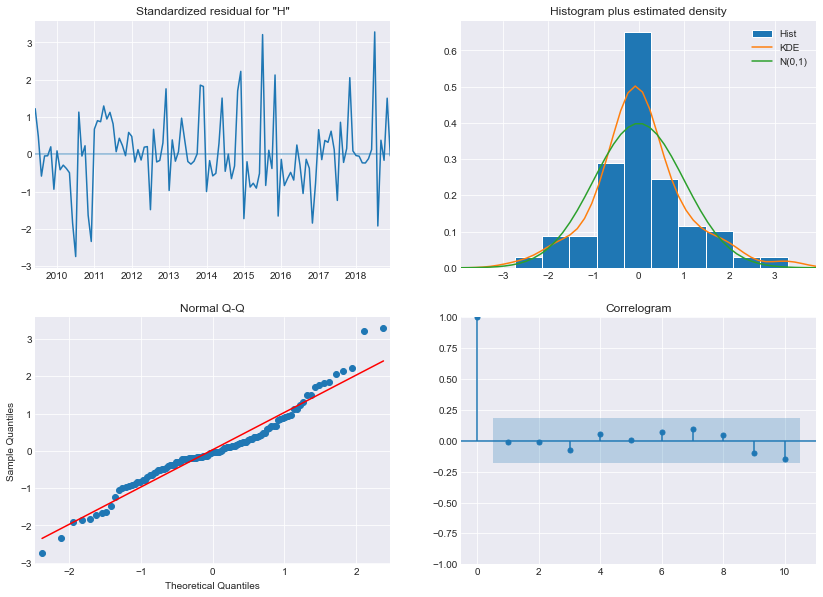

In [29]:
results.plot_diagnostics(figsize=(14,10))

In [30]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

HB_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,1.301343,0.065402,1.173157,1.429529
2019-02-01,1.302852,0.073582,1.158634,1.447070
2019-03-01,1.312151,0.073974,1.167166,1.457137
2019-04-01,1.311648,0.074242,1.166136,1.457160
2019-05-01,1.238431,0.075294,1.090858,1.386004
2019-06-01,1.047885,0.076797,0.897366,1.198403
2019-07-01,0.557554,0.078145,0.404393,0.710715
2019-08-01,0.141783,0.079311,-0.013664,0.297229
2019-09-01,0.068535,0.080434,-0.089113,0.226184
2019-10-01,0.092831,0.081571,-0.067046,0.252708


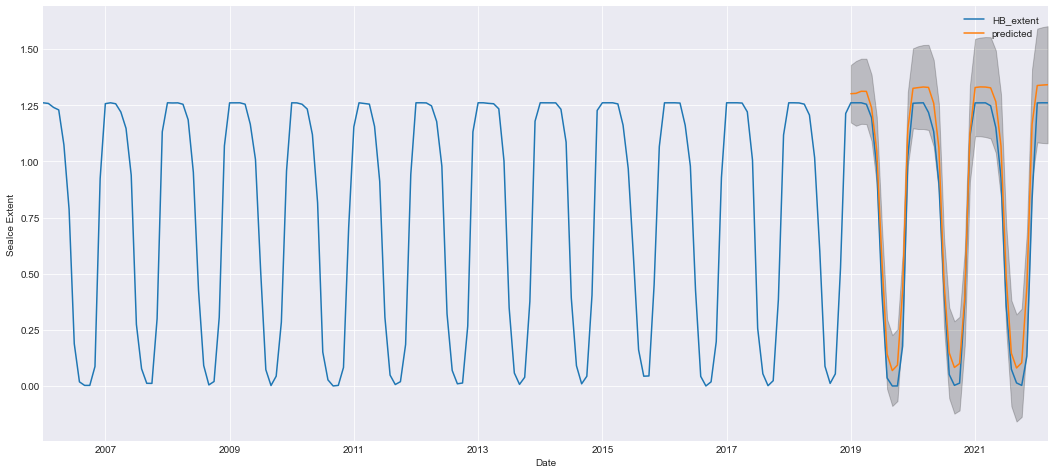

In [31]:
ax = df_monthlyextent.plot(x='date', y='HB_extent')
forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()

In [32]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent, forecast_values.predicted_mean, squared=False),3)))

RMSE(Sarimax): 0.119


#### Central Arctic

In [33]:
df_ca_mod = pd.read_csv('../data/CA.csv')
extent_month_ca=df_ca_mod.groupby(['year', 'month'])['CA_extent'].mean()
df_monthlyextent_ca = extent_month_ca.to_frame()
extent_month_ca.head()

year  month
2006  1        3.188713e+06
      2        3.190598e+06
      3        3.240802e+06
      4        3.185823e+06
      5        3.153358e+06
Name: CA_extent, dtype: float64

In [34]:
months = []
years = []

for i, x in enumerate(df_monthlyextent_ca['CA_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent_ca['year'] = years
df_monthlyextent_ca['month'] = months
df_monthlyextent_ca['day'] = 1

df_monthlyextent_ca['date'] = pd.to_datetime(df_monthlyextent_ca[['year', 'month', 'day']])
df_monthlyextent_ca.reset_index(drop=True, inplace=True)
df_monthlyextent_ca.head()

,CA_extent,year,month,day,date
0,3.188713e+06,2006,1,1,2006-01-01
1,3.190598e+06,2006,2,1,2006-02-01
2,3.240802e+06,2006,3,1,2006-03-01
3,3.185823e+06,2006,4,1,2006-04-01
4,3.153358e+06,2006,5,1,2006-05-01


In [35]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent_ca = df_monthlyextent_ca['CA_extent']

train_size_monthly_ca = int(len(X_monthlyextent_ca)*0.8038)
train_monthlyextent_ca, test_monthlyextent_ca = X_monthlyextent_ca[1:train_size_monthly_ca], X_monthlyextent_ca[train_size_monthly_ca:]
print('Observations: %d' % (len(X_monthlyextent_ca)))
print('Training Observations: %d' % (len(train_monthlyextent_ca)))
print('Testing Observations: %d' % (len(test_monthlyextent_ca)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [36]:
#SARIMA(2, 1, 2)x(2, 1, 1, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent_ca,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 9.079404
         Iterations: 15
         Function evaluations: 1642
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0866      0.234      0.370      0.711      -0.372       0.545
ar.L2         -0.0087      0.251     -0.035      0.972      -0.501       0.484
ma.L1         -0.2906      0.251     -1.159      0.247      -0.782       0.201
ma.L2         -0.0540      0.288     -0.188      0.851      -0.618       0.510
ar.S.L12       0.7412      0.103      7.170      0.000       0.539       0.944
ar.S.L24      -0.7471      0.065    -11.464      0.000      -0.875      -0.619
ma.S.L12      -0.8451      0.107     -7.890      0.000      -1.055      -0.635
ma.S.L24       0.5417      0.058      9.312      0.000       0.428       0.656
sigma2      2.513e+09   1.15e-10   2.19e+19      0.000    2.51e+09    

In [37]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

CA_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
156,3.147369e+06,50124.951612,3.049126e+06,3.245612e+06
157,3.080205e+06,64064.153886,2.954641e+06,3.205768e+06
158,3.096977e+06,73421.789257,2.953073e+06,3.240881e+06
159,3.147060e+06,81601.057799,2.987125e+06,3.306996e+06
160,3.106295e+06,89037.039256,2.931786e+06,3.280805e+06
161,3.046308e+06,95899.393070,2.858349e+06,3.234267e+06
162,3.010055e+06,102302.520398,2.809546e+06,3.210565e+06
163,2.827779e+06,108327.821085,2.615460e+06,3.040097e+06
164,2.816816e+06,114035.204097,2.593311e+06,3.040321e+06
165,2.900575e+06,119470.242026,2.666418e+06,3.134732e+06


In [38]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent_ca, forecast_values.predicted_mean, squared=False),3)))

RMSE(Sarimax): 177837.853


#### Sea of Okhotsk

In [39]:
extent_month_so=df_ca_mod.groupby(['year', 'month'])['SO_extent'].mean()
df_monthlyextent_so = extent_month_so.to_frame()
df_monthlyextent_so.head()

SO_extent
year month               
2006 1      433881.107742
     2      754421.181786
     3      795021.644194
     4      510972.706000
     5      196972.454516

In [40]:
months = []
years = []

for i, x in enumerate(df_monthlyextent_so['SO_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent_so['year'] = years
df_monthlyextent_so['month'] = months
df_monthlyextent_so['day'] = 1

df_monthlyextent_so['date'] = pd.to_datetime(df_monthlyextent_so[['year', 'month', 'day']])
df_monthlyextent_so.reset_index(drop=True, inplace=True)
df_monthlyextent_so.head()

,SO_extent,year,month,day,date
0,433881.107742,2006,1,1,2006-01-01
1,754421.181786,2006,2,1,2006-02-01
2,795021.644194,2006,3,1,2006-03-01
3,510972.706000,2006,4,1,2006-04-01
4,196972.454516,2006,5,1,2006-05-01


In [41]:
df_monthlyextent_so.set_index('date', drop=False, inplace=True)
df_monthlyextent_so['SO_extent'] /= 1000000
df_monthlyextent_so.head()

,SO_extent,year,month,day,date
date,,,,,
2006-01-01,0.433881,2006,1,1,2006-01-01
2006-02-01,0.754421,2006,2,1,2006-02-01
2006-03-01,0.795022,2006,3,1,2006-03-01
2006-04-01,0.510973,2006,4,1,2006-04-01
2006-05-01,0.196972,2006,5,1,2006-05-01


In [42]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent_so = df_monthlyextent_so['SO_extent']

train_size_monthly_so = int(len(X_monthlyextent_so)*0.8)
train_monthlyextent_so, test_monthlyextent_so = X_monthlyextent_so[1:train_size_monthly_so], X_monthlyextent_so[train_size_monthly_so:]
print('Observations: %d' % (len(X_monthlyextent_so)))
print('Training Observations: %d' % (len(train_monthlyextent_so)))
print('Testing Observations: %d' % (len(test_monthlyextent_so)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [43]:
#SARIMA(2, 1, 2)x(2, 1, 1, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent_so,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: -0.889577
         Iterations: 8
         Function evaluations: 939
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5147      0.154      3.341      0.001       0.213       0.817
ar.L2         -0.3197      0.087     -3.675      0.000      -0.490      -0.149
ma.L1         -0.6105      0.160     -3.819      0.000      -0.924      -0.297
ma.L2         -0.2686      0.150     -1.791      0.073      -0.563       0.025
ar.S.L12      -0.9392      0.119     -7.921      0.000      -1.172      -0.707
ar.S.L24      -0.0976      0.110     -0.888      0.374      -0.313       0.118
ma.S.L12      -0.1130      2.893     -0.039      0.969      -5.784       5.558
ma.S.L24      -0.9010      2.521     -0.357      0.721      -5.842       4.040
sigma2         0.0040      0.011      0.347      0.728      -0.019     

In [44]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

SO_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,0.610807,0.066924,0.479637,0.741976
2019-02-01,0.945507,0.090154,0.768809,1.122205
2019-03-01,0.999281,0.091640,0.819669,1.178893
2019-04-01,0.634267,0.091573,0.454787,0.813747
2019-05-01,0.225228,0.091576,0.045741,0.404714
2019-06-01,0.053629,0.092012,-0.126712,0.233970
2019-07-01,0.013810,0.092822,-0.168117,0.195738
2019-08-01,0.010508,0.093520,-0.172789,0.193805
2019-09-01,0.010969,0.094051,-0.173367,0.195305
2019-10-01,0.011410,0.094529,-0.173863,0.196683


In [45]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent_so, forecast_values.predicted_mean, squared=False),4)))

RMSE(Sarimax): 0.0827


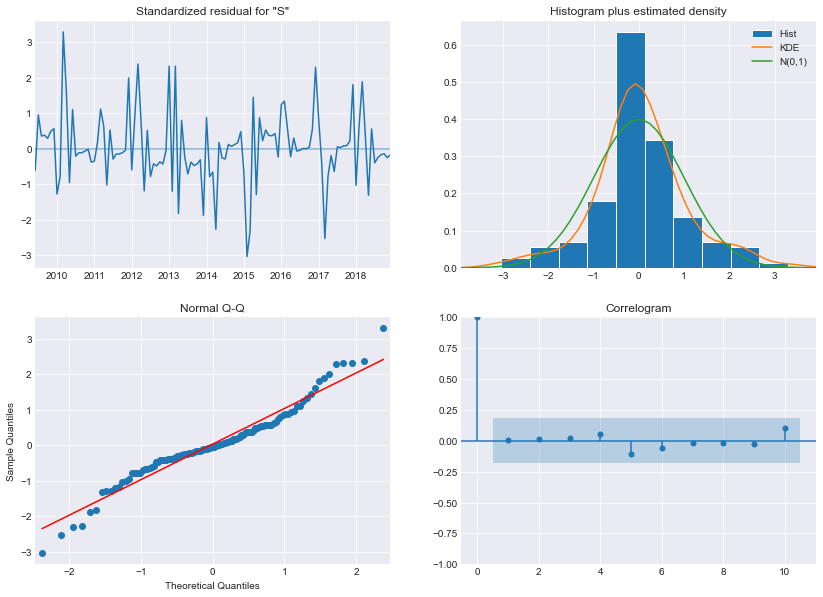

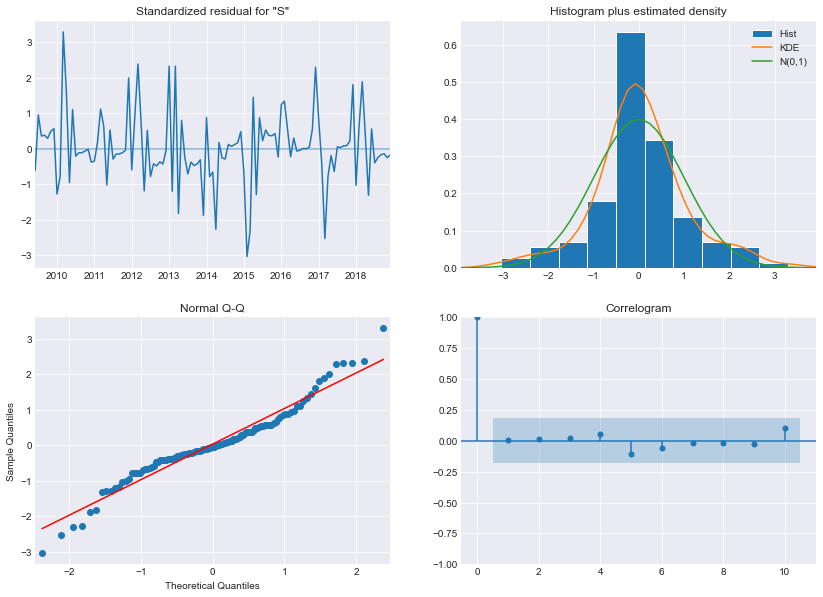

In [46]:
results.plot_diagnostics(figsize=(14,10))

In [47]:
df_test_monthlyextent_so = df_monthlyextent_so.iloc[train_size_monthly_so:]
df_test_monthlyextent_so = df_test_monthlyextent_so.reset_index(drop=True)
df_test_monthlyextent_so.head()

,SO_extent,year,month,day,date
0,0.640751,2019,1,1,2019-01-01
1,1.082026,2019,2,1,2019-02-01
2,1.201253,2019,3,1,2019-03-01
3,0.566847,2019,4,1,2019-04-01
4,0.102950,2019,5,1,2019-05-01


In [48]:
# calculate residuals
residuals = [test_monthlyextent_so[i]-forecast_values.predicted_mean[i] for i in range(len(test_monthlyextent_so))]
#residuals = pd.DataFrame(residuals)

df_test_monthlyextent_so['residuals'] = residuals

# plot residuals
df_test_monthlyextent_so.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SO_extent  39 non-null     float64       
 1   year       39 non-null     int64         
 2   month      39 non-null     int64         
 3   day        39 non-null     int64         
 4   date       39 non-null     datetime64[ns]
 5   residuals  39 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 2.0 KB


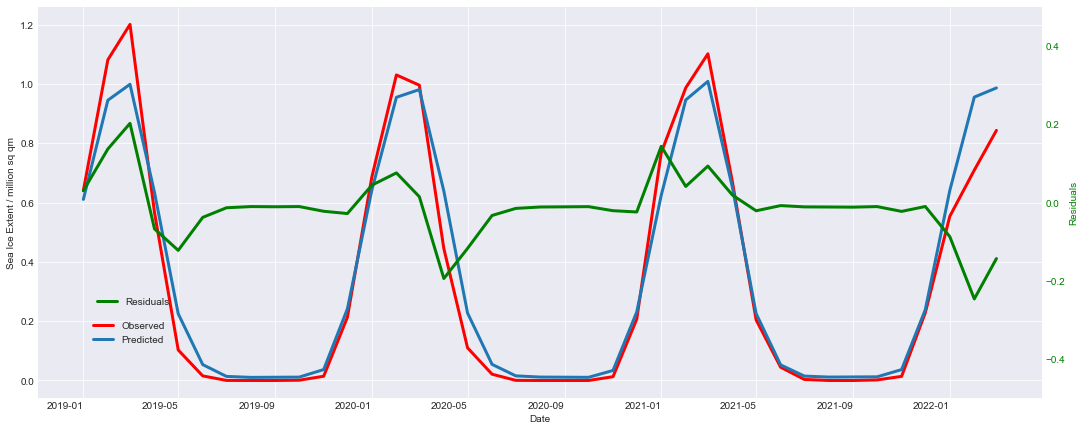

In [49]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(x='date', y='SO_extent', data=df_test_monthlyextent_so, color='red', label='Observed', ax=ax1, linewidth=3)
forecast_values.predicted_mean.plot(ax=ax1, label='Predicted', linewidth=3)
#sns.lineplot(x='ds', y='yhat', data=predict_test_h, color='blue', label='Predicted', ax=ax1)
sns.lineplot(x='date', y='residuals', data=df_test_monthlyextent_so, color='green',label='Residuals', ax=ax2, linewidth=3)
ax1.legend(bbox_to_anchor=(0.1355, 0.22))
ax2.legend(bbox_to_anchor=(0.14, 0.28))
ax1.tick_params(axis='y')
ax1.set_ylabel('Sea Ice Extent / million sq qm')
ax1.set_xlabel('Date')
plt.setp(ax1.get_xticklabels(), rotation=0)
#ax1.set(title='Sales and Forecast (solo)')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('Residuals', fontdict={'color': 'green'})
ax2.set_ylim(-0.5,0.5)
plt.savefig('../images/resid_so.png')

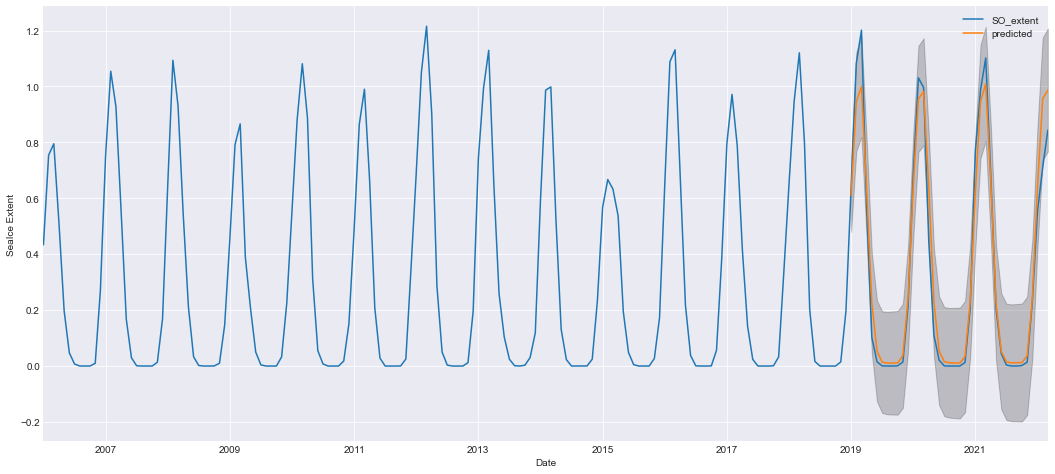

In [50]:
ax = df_monthlyextent_so.plot(x='date', y='SO_extent')

forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()